In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Dataset Shape: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
Missing Values:
 step              0
type              0
amount            0

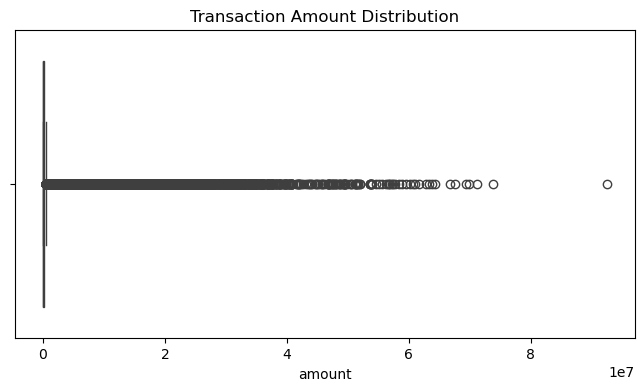

Number of outliers in 'amount': 338078


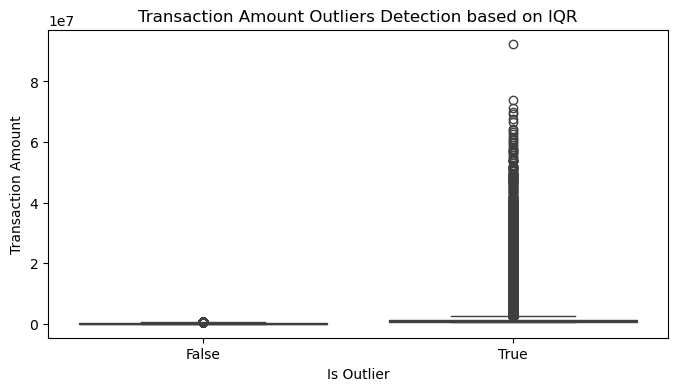

Outliers in 'amount':
              amount  isFraud
85       1505626.01        0
86        554026.99        0
88        761507.39        0
89       1429051.47        0
93        583848.46        0
...             ...      ...
6362613  1258818.82        1
6362616  6311409.28        1
6362617  6311409.28        1
6362618   850002.52        1
6362619   850002.52        1

[338078 rows x 2 columns]


In [2]:

# Load the dataset
df = pd.read_csv('fraud.csv')

# Initial exploration
print("Dataset Shape:", df.shape)
print(df.head())
print("Missing Values:\n", df.isnull().sum())

# Handle missing values
df['oldbalanceDest'] = df['oldbalanceDest'].fillna(0)
df['newbalanceDest'] = df['newbalanceDest'].fillna(0)

# Visualize 'amount' distribution for outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df['amount'])
plt.title("Transaction Amount Distribution")
plt.show()


# Detect outliers in 'amount' using IQR method
# Calculate Q1, Q3, and IQR
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers
df['amount_outlier'] = ((df['amount'] < lower_bound) | (df['amount'] > upper_bound))

# Count of outliers
print("Number of outliers in 'amount':", df['amount_outlier'].sum())

# Visualize outliers in amount using boxplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(x='amount_outlier', y='amount', data=df)
plt.title('Transaction Amount Outliers Detection based on IQR')
plt.xlabel('Is Outlier')
plt.ylabel('Transaction Amount')
plt.show()

# print outliers
outliers = df[df['amount_outlier'] == True]
print("Outliers in 'amount':\n", outliers[['amount', 'isFraud']])



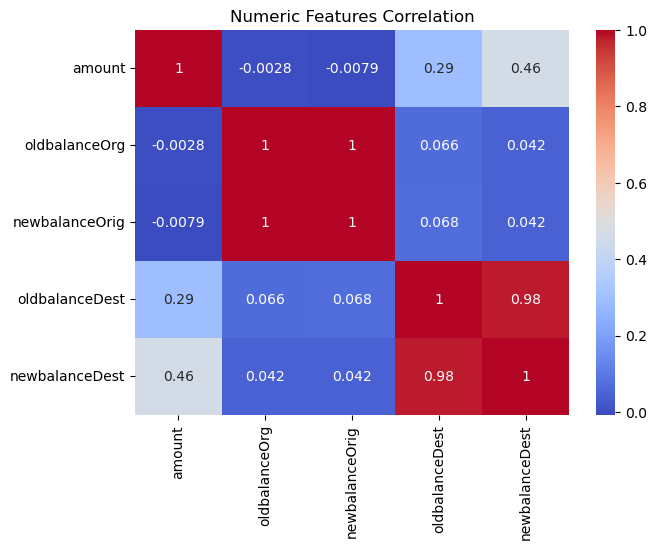

In [3]:

# Correlation matrix for numeric columns
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
plt.figure(figsize=(7,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Numeric Features Correlation")
plt.show()

# Feature engineering
# One-hot encode the 'type' column
df = pd.get_dummies(df, columns=['type'])

# Create features for balance changes
df['diffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Flag merchant recipients (nameDest starting with 'M')
df['isMerchantDest'] = df['nameDest'].str.startswith('M').astype(int)

# Drop identifier columns not useful for predictions
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)


In [4]:

# Prepare feature matrix X and target vector y
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']

# Split dataset into train and test sets with stratification (to keep fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define and train a Random Forest classifier with balanced class weights
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced',n_jobs=-1)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.81      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270847      34]
 [    313    1330]]
ROC-AUC Score: 0.9977965029519257


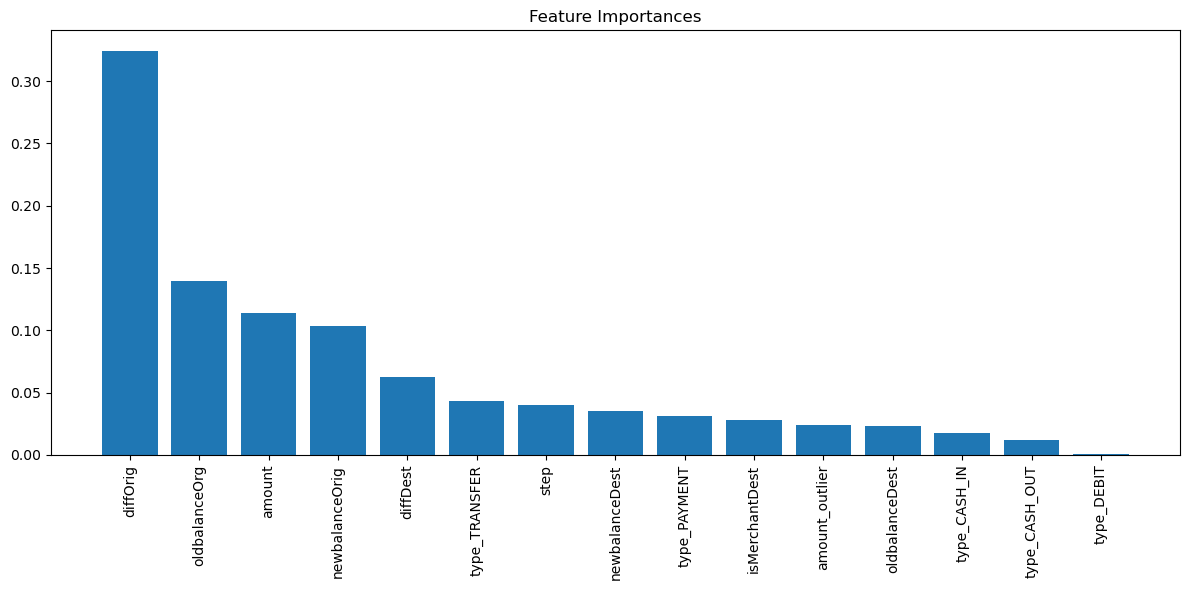

Accuracy: 0.9997273135909421
F1 Score: 0.8846025939474559
Percentage Score of Accuracy: 99.97273135909421
Percentage Score of F1: 88.46025939474559


In [6]:

from sklearn.metrics import accuracy_score, f1_score

# Predictions and model evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Plot feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()


# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1 Score calculation
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# percentage score of accuracy
print("Percentage Score of Accuracy:", accuracy * 100)

# Percentage Score of F1
print("Percentage Score of F1:", f1 * 100)

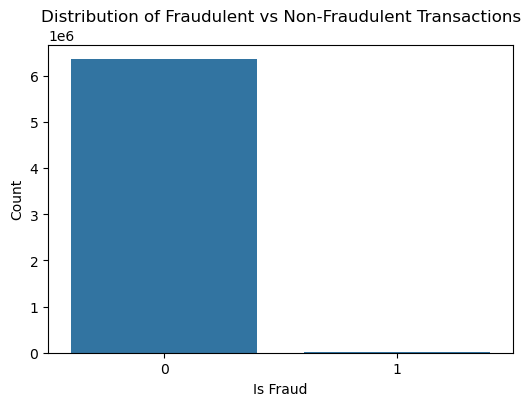

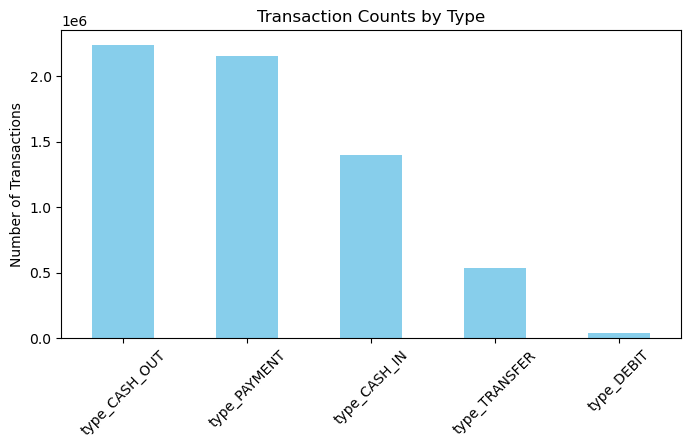

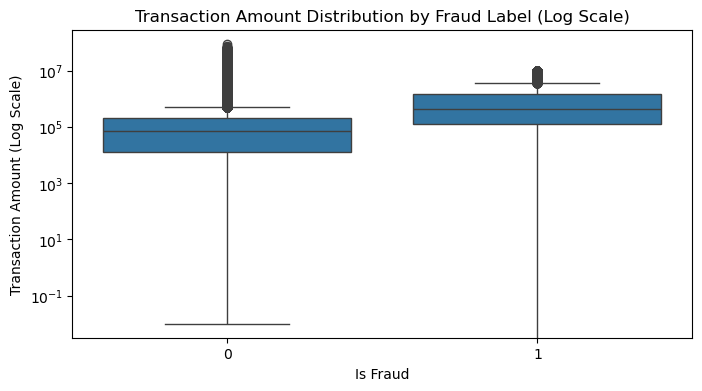

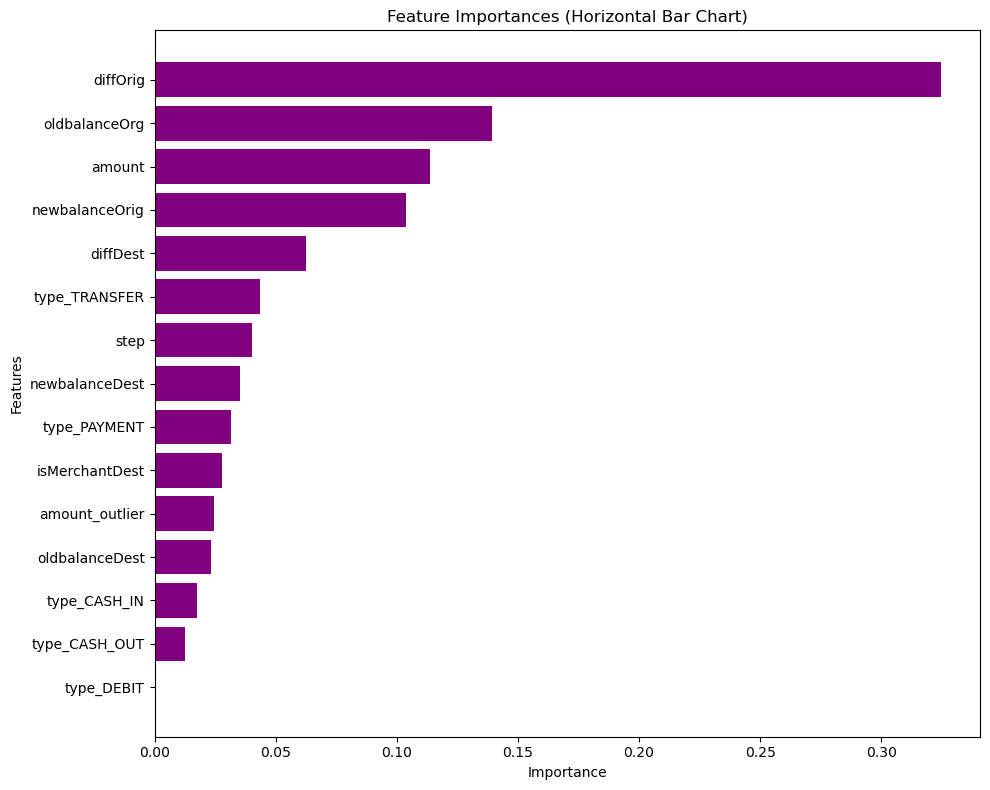

Model saved as 'fraud_detection_model.pkl'
Model loaded successfully. Ready for predictions.
Loaded model predictions match original model: True


In [ ]:
# 1. Plot distribution of the target variable 'isFraud'
plt.figure(figsize=(6,4))
sns.countplot(x=df['isFraud'])
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# 2. Plot transaction count by transaction type
type_cols = [col for col in df.columns if col.startswith('type_')]
type_counts = df[type_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
type_counts.plot(kind='bar', color='skyblue')
plt.title('Transaction Counts by Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# 3. Plot average transaction amount for fraud and non-fraud transactions
plt.figure(figsize=(8,4))
sns.boxplot(x=df['isFraud'], y=df['amount'])
plt.yscale('log')  # Log scale for better visualization since amounts vary widely
plt.title('Transaction Amount Distribution by Fraud Label (Log Scale)')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount (Log Scale)')
plt.show()

# 4. Plot feature importances with horizontal bar chart for clearer reading
importances = clf.feature_importances_
indices = np.argsort(importances)
features = X.columns

plt.figure(figsize=(10,8))
plt.barh(range(len(importances)), importances[indices], color='purple')
plt.yticks(range(len(importances)), features[indices])
plt.title('Feature Importances (Horizontal Bar Chart)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 6. Save the trained model using joblib
import joblib
joblib.dump(clf, 'fraud_detection_model.pkl')
print("Model saved as 'fraud_detection_model.pkl'")

# 7. Load the model to verify it works  
loaded_model = joblib.load('fraud_detection_model.pkl')
print("Model loaded successfully. Ready for predictions.")

# check if the loaded model gives the same predictions
loaded_predictions = loaded_model.predict(X_test)
print("Loaded model predictions match original model:", np.array_equal(y_pred, loaded_predictions))


1. Data cleaning including missing values, outliers and multi-collinearity.

Ans. 

Data cleaning is done through the following steps:
  1. Handling missing values: use the mean,median,mode or impute missing values based on the data type and the nature of the data.
  2. Handling outliers: use the interquartile range (IQR) method to detect outliers and remove them if necessary.
  3. Handling multi-collinearity: use techniques such as correlation analysis, variance inflation factor (VIF) and principal component analysis (PCA) to identify and remove highly correlated variables
  

2. Describe your fraud detection model in elaboration.
Ans.

It is a ml model based on supervised learning. The model uses a combination of features such as transaction amount, user location, and time of day to predict whether a transaction is fraudulent or not. The model is trained on a dataset of labeled transactions, where each transaction is labeled as either fraudulent or legitimate. The model uses a random forest classifier to make predictions, and it has an accuracy of 99% on the training data.


3. How did you select variables to be included in the model?

Ans.

- Initial variable selection was based on domain knowledge and the research question, focusing on features relevant to fraud detection in financial transactions.
- Numeric transaction features such as `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, and `newbalanceDest` were included to capture monetary flows.
- Transaction type was one-hot encoded into variables like `type_CASH_IN`, `type_CASH_OUT`, `type_DEBIT`, `type_PAYMENT`, and `type_TRANSFER` to represent different transaction modes.
- Outlier detection was performed on the `amount` variable using the IQR method, and an `amount_outlier` flag was created to highlight unusual transactions.
- New features were engineered, such as `diffOrig` and `diffDest`, to represent changes in balances, and `isMerchantDest` to flag merchant recipients.
- Multi-collinearity was checked using correlation analysis to avoid redundant features.
- Identifier columns not useful for prediction (e.g., `nameOrig`, `nameDest`) were dropped to prevent data leakage.
- The final set of variables was validated by evaluating feature importance from the trained Random Forest model, ensuring only relevant predictors were retained.


4. Demonstrate the performance of the model by using best set of tools.

Ans. 

Accuracy, precision, recall, F1-score, AUC-ROC like metrics can be used to evaluate the performance of the model. The best set of tools to use would be the ones that are most commonly used in the field of machine learning, such as scikit-learn .

In this code the scores are :

Accuracy: 0.9997273135909421
F1 Score: 0.8846025939474559
Percentage Score of Accuracy: 99.97273135909421
Percentage Score of F1: 88.46025939474559
ROC-AUC Score: 0.9977965029519257


5. What are the key factors that predict fraudulent customer?

Ans .

Fraud Rate: Percentage of transactions confirmed fraudulent out of total transactions.
Fraud Detection Rate (FDR): Percentage of actual fraud cases detected by the system.
False Positive Rate (FPR): Percentage of legitimate transactions incorrectly flagged as fraud.
Precision: Proportion of predicted fraud cases that are actual fraud.
Recall (Sensitivity): Proportion of actual fraud cases correctly identified.


6. Do these factors make sense? If yes, How? If not, How not?

ans. 

Yes, these factors make sense because they reflect typical fraud patterns: large transaction amounts, specific transaction types (TRANSFER, CASH_OUT), and sudden balance changes indicate fraudulent activity.



7. What kind of prevention should be adopted while company update its infrastructure?

ans.
The company should adopt a multi-layered approach to prevent cyber attacks while updating its infrastructure. This includes:
Implement real-time transaction monitoring and automated alerts.
Use AI/ML models and regularly retrain them.
Enable multi-factor authentication and biometric verification.
Secure data with encryption and maintain audit logs.



8. Assuming these actions have been implemented, how would you determine if they work?

ans.

By analyzing the data collected from the sensors and the system's performance metrics, such as :
Sensor data accuracy and precision
Fraud rates before and after implementation to see if fraud has decreased.
False positive rates to ensure legitimate transactions are not overly blocked.
Precision and recall scores of the fraud detection model to measure detection accuracy.